In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import glob
import geopandas
import cartopy.feature as cfeature
import numpy as np
from cartopy import crs as ccrs
from shapely import geometry
from asmclib import geohotspot
from datetime import datetime

In [2]:
df_grid = geopandas.read_file('./shapefile/5km_grid.geojson')
df_grid.crs = {'init': 'epsg:3857'}

In [4]:
geo_hs = geohotspot.GeoHotspot
date_process = datetime(2019, 10, 12)
start_hr = 0
start_min = 0
end_hr = 8
end_min = 30
start_date = date_process.replace(hour=start_hr, minute=start_min)
end_date = date_process.replace(hour=end_hr, minute=end_min)

In [5]:
geo_obs_count = int((start_date - end_date).seconds/600)
print ((start_date - end_date).seconds)
print ((start_date - end_date).seconds)

55800
55800


In [8]:
pd.DataFrame?

Init signature: pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)
Docstring:     
Two-dimensional size-mutable, potentially heterogeneous tabular data
structure with labeled axes (rows and columns). Arithmetic operations
align on both row and column labels. Can be thought of as a dict-like
container for Series objects. The primary pandas data structure.

Parameters
----------
data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
    Dict can contain Series, arrays, constants, or list-like objects

    .. versionchanged :: 0.23.0
       If data is a dict, argument order is maintained for Python 3.6
       and later.

index : Index or array-like
    Index to use for resulting frame. Will default to RangeIndex if
    no indexing information part of input data and no index provided
columns : Index or array-like
    Column labels to use for resulting frame. Will default to
    RangeIndex (0, 1, 2, ..., n) if no column labels are provided
dtype : dt

In [7]:
h8_files = "./hotspots/ahi/H08_*" + date_process.strftime('%Y%m%d') + "*_L2WLFbet_FLDK.06001_06001.csv"
geo_hs.parse_jaxa_hotspot_txt?(file_path=h8_files)

Signature: geo_hs.parse_jaxa_hotspot_txt(self, file_path)
Docstring:
Parse the JAXA hotspot text

Returns:
    a Pandas DataFrame with coordinates, fire radiative power, detection confidence,
    timestamp and satellite of hotspots        
File:      c:\users\wong songhan\desktop\project fred\asmclib\geohotspot.py
Type:      function


In [6]:
jp1_files = "./hotspots/viirs/" + date_process.strftime('%Y%m%d') + "*JP1*.txt"
geo_hs.parse_viirs_afedr_txt(file_path=jp1_files, sat_name='NOAA20', convert_local_dt=False)

C:\Users\Wong Songhan\Desktop\Project FRED\asmclib\geohotspot.py:287: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  self.hs_df = pd.concat([hs_viirs_df, self.hs_df])


In [7]:
npp_files = "./hotspots/viirs/" + date_process.strftime('%Y%m%d') + "*NPP*.txt"
geo_hs.parse_viirs_afedr_txt(file_path=npp_files, sat_name='NPP')

In [8]:
modis_files = "./hotspots/modis/*14." + date_process.strftime('%y%j') + "*.txt"
geo_hs.parse_modis_mod14_txt(file_path=modis_files)

C:\Users\Wong Songhan\Desktop\Project FRED\asmclib\geohotspot.py:235: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  self.hs_df = pd.concat([hs_modis_df, self.hs_df])


In [9]:
geo_df = geo_hs.hs_df.copy()

In [10]:
start_date_str = start_date.strftime("%d/%m/%Y %H:%M:%S")
end_date_str = end_date.strftime("%d/%m/%Y %H:%M:%S")
geo_df = geo_df[(geo_df['date'] >= start_date_str) & (geo_df['date'] <= end_date_str)]

In [11]:
geo_df.loc[geo_df['confidence'] == 'NA', 'confidence'] = 0

In [12]:
num_polar_sat = len(geo_df.loc[geo_df['satellite'] != 'Himawari-8/9', 'satellite'].unique())

In [13]:
alpha = 1.0
polar_weight = alpha * geo_obs_count/num_polar_sat
max_weight = geo_obs_count + polar_weight * num_polar_sat * alpha

In [14]:
print (geo_obs_count, polar_weight, max_weight)

93 23.25 186.0


Let $W_i$ to be total weight based on hotspots detected by geostationary and polar-orbiting satellites, and $i$ is the position of grid

$$ W_i = \sum_{j}^{n_g} (1 - \alpha) \frac{1}{n_{g}} + \sum_{k}^{n_p} \alpha \frac{1}{n_p} c_j$$ 

$$ P_i = W_i^{1/\gamma} $$

where

$\alpha$ is the ratio of contribution by geostationary and polar orbiters. If $\alpha = 0$, it means there are no polar orbiters included. If $\alpha = 1$, it means there are no geostationary satellites included.

$n_g$ is the maximum number of geostationary observations made during the window period.

$c_j$ is the normalized confidence level (scaled to 1.0)

$n_p$ is the number of polar orbiting satellites (4 - N20, TERRA, AQUA, NPP), $k$ is the identifier of the polar satellite 

$\gamma$ = 2


In [15]:
geo_df['geo_weight'] = 0.0
geo_df['polar_weight'] = 0.0

geo_df.loc[geo_df['satellite'] == "Himawari-8/9", 'geo_weight'] = 1/max_weight
geo_df['polar_weight'] = (polar_weight/max_weight) * (geo_df['confidence']/100)
geo_df['weight'] = geo_df['geo_weight'] + geo_df['polar_weight']
geo_df

,FRP,QC,confidence,date,daynight,lat,lon,satellite,geo_weight,polar_weight,weight
0,5.7,NaN,59,12/10/2019 03:14:38,day,24.60500,113.56900,TERRA,0.000000,0.07375,0.073750
1,9.4,NaN,65,12/10/2019 03:14:38,day,24.60500,109.25900,TERRA,0.000000,0.08125,0.081250
2,5.9,NaN,48,12/10/2019 03:14:38,day,24.33800,110.30600,TERRA,0.000000,0.06000,0.060000
3,5.9,NaN,56,12/10/2019 03:14:38,day,24.01400,111.39600,TERRA,0.000000,0.07000,0.070000
4,7.3,NaN,35,12/10/2019 03:14:38,day,23.38500,112.73300,TERRA,0.000000,0.04375,0.043750
5,6,NaN,17,12/10/2019 03:14:38,day,23.33300,112.83400,TERRA,0.000000,0.02125,0.021250
6,7.7,NaN,62,12/10/2019 03:14:38,day,23.24100,111.58000,TERRA,0.000000,0.07750,0.077500
7,13,NaN,73,12/10/2019 03:14:38,day,23.26500,110.89300,TERRA,0.000000,0.09125,0.091250
8,7,NaN,38,12/10/2019 03:14:38,day,22.89100,112.82600,TERRA,0.000000,0.04750,0.047500
9,7.4,NaN,15,12/10/2019 03:14:38,day,22.94900,112.13200,TERRA,0.000000,0.01875,0.018750


In [16]:
gdf = geopandas.GeoDataFrame(geo_df, geometry=geopandas.points_from_xy(geo_df.lon, geo_df.lat))

In [17]:
gdf.crs = {'init' :'epsg:4326'}
gdf_merc = gdf.to_crs({'init': 'epsg:3857'})

In [18]:
gdf_merc.reset_index(inplace = True) 

In [19]:
gdf_merc['x'] = gdf_merc['geometry'].x

In [20]:
gdf_merc['y'] = gdf_merc['geometry'].y

In [21]:
sat_resolution_meter = {
    'TERRA': 1000,
    'AQUA': 1000,
    'Himawari-8/9': 2200,
    'NPP': 750,
    'NOAA20': 750
}

In [22]:
for key, value in sat_resolution_meter.items():
    gdf_merc.loc[gdf_merc['satellite'] == key, 'resolution_meter'] = value

In [23]:
gdf_merc['resolution_meter'].unique()

array([1000.,  750., 2200.])

In [24]:
gdf_merc.head()

,index,FRP,QC,confidence,date,daynight,lat,lon,satellite,geo_weight,polar_weight,weight,geometry,x,y,resolution_meter
0,0,5.7,NaN,59,12/10/2019 03:14:38,day,24.605,113.569,TERRA,0.0,0.07375,0.07375,POINT (12642443.250 2827305.210),1.264244e+07,2.827305e+06,1000.0
1,1,9.4,NaN,65,12/10/2019 03:14:38,day,24.605,109.259,TERRA,0.0,0.08125,0.08125,POINT (12162656.245 2827305.210),1.216266e+07,2.827305e+06,1000.0
2,2,5.9,NaN,48,12/10/2019 03:14:38,day,24.338,110.306,TERRA,0.0,0.06000,0.06000,POINT (12279207.751 2794649.304),1.227921e+07,2.794649e+06,1000.0
3,3,5.9,NaN,56,12/10/2019 03:14:38,day,24.014,111.396,TERRA,0.0,0.07000,0.07000,POINT (12400545.996 2755114.163),1.240055e+07,2.755114e+06,1000.0
4,4,7.3,NaN,35,12/10/2019 03:14:38,day,23.385,112.733,TERRA,0.0,0.04375,0.04375,POINT (12549380.156 2678644.753),1.254938e+07,2.678645e+06,1000.0


In [25]:
hotspot_json = './output/hotspot_' + date_process.strftime('%Y%m%d') + '.geojson'
gdf_merc.to_file(hotspot_json, driver='GeoJSON')

In [26]:
from shapely.geometry import box

def get_poly_box(x, y, res_m):
    delta_x = res_m * 0.5
    delta_y = res_m * 0.5 
    poly = box(x - delta_x, y - delta_y , x + delta_x, y + delta_y)
    return poly

In [27]:
for index, row in gdf_merc.iterrows():
    gdf_merc['geometry'].iloc[index] = get_poly_box(row['x'], row['y'], row['resolution_meter'])

In [28]:
gdf_merc.head()

,index,FRP,QC,confidence,date,daynight,lat,lon,satellite,geo_weight,polar_weight,weight,geometry,x,y,resolution_meter
0,0,5.7,NaN,59,12/10/2019 03:14:38,day,24.605,113.569,TERRA,0.0,0.07375,0.07375,"POLYGON ((12642943.250 2826805.210, 12642943.2...",1.264244e+07,2.827305e+06,1000.0
1,1,9.4,NaN,65,12/10/2019 03:14:38,day,24.605,109.259,TERRA,0.0,0.08125,0.08125,"POLYGON ((12163156.245 2826805.210, 12163156.2...",1.216266e+07,2.827305e+06,1000.0
2,2,5.9,NaN,48,12/10/2019 03:14:38,day,24.338,110.306,TERRA,0.0,0.06000,0.06000,"POLYGON ((12279707.751 2794149.304, 12279707.7...",1.227921e+07,2.794649e+06,1000.0
3,3,5.9,NaN,56,12/10/2019 03:14:38,day,24.014,111.396,TERRA,0.0,0.07000,0.07000,"POLYGON ((12401045.996 2754614.163, 12401045.9...",1.240055e+07,2.755114e+06,1000.0
4,4,7.3,NaN,35,12/10/2019 03:14:38,day,23.385,112.733,TERRA,0.0,0.04375,0.04375,"POLYGON ((12549880.156 2678144.753, 12549880.1...",1.254938e+07,2.678645e+06,1000.0


In [29]:
hotspot_polygon_json = './output/hotspot_polygon_' + date_process.strftime('%Y%m%d') + '.geojson'
gdf_merc.to_file(hotspot_polygon_json, driver='GeoJSON')

In [30]:
min_x = 10500000 
max_x = 13500000
min_y = -900000
max_y = 2500000
print (min_x, max_x, min_y, max_y)

10500000 13500000 -900000 2500000


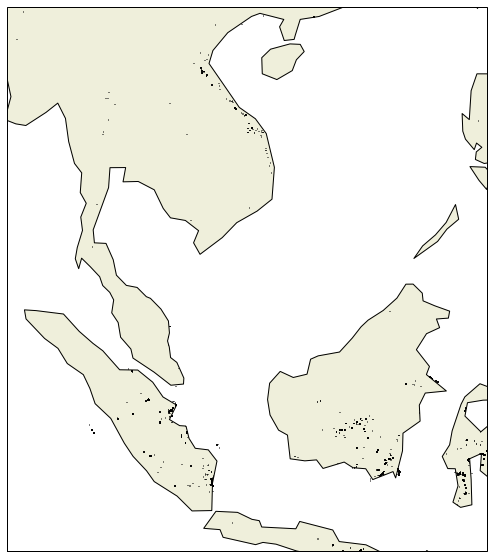

In [31]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([min_x, max_x, min_y, max_y], crs=ccrs.Mercator())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
# Make the CartoPy plot
crs_epsg = ccrs.epsg('3857')
ax.add_geometries(gdf_merc['geometry'], crs=crs_epsg, facecolor='white', edgecolor='black')

In [30]:
df_grid_joined = geopandas.sjoin(df_grid, gdf_merc, op='intersects')

In [31]:
df_grid_joined.head()

,id,xmin,xmax,ymin,ymax,geometry,index_right,index,FRP,QC,...,daynight,lat,lon,satellite,geo_weight,polar_weight,weight,x,y,resolution_meter
20371,20371,1.137820e+07,1.138320e+07,3.212427e+06,3.217427e+06,"POLYGON ((11378195.639 3217427.110, 11383195.6...",2533,1146,23.1177,NaN,...,day,27.725304,102.217026,NOAA20,0.000000,0.11125,0.111250,1.137875e+07,3.214385e+06,750.0
20736,20736,1.320320e+07,1.320820e+07,3.212427e+06,3.217427e+06,"POLYGON ((13203195.639 3217427.110, 13208195.6...",2848,260,NA,'001000',...,day,27.720000,118.620000,Himawari-8/9,0.005376,0.00000,0.005376,1.320472e+07,3.213718e+06,2200.0
20736,20736,1.320320e+07,1.320820e+07,3.212427e+06,3.217427e+06,"POLYGON ((13203195.639 3217427.110, 13208195.6...",2849,261,NA,'001000',...,day,27.720000,118.640000,Himawari-8/9,0.005376,0.00000,0.005376,1.320694e+07,3.213718e+06,2200.0
20736,20736,1.320320e+07,1.320820e+07,3.212427e+06,3.217427e+06,"POLYGON ((13203195.639 3217427.110, 13208195.6...",3221,633,NA,'001000',...,day,27.720000,118.620000,Himawari-8/9,0.005376,0.00000,0.005376,1.320472e+07,3.213718e+06,2200.0
20736,20736,1.320320e+07,1.320820e+07,3.212427e+06,3.217427e+06,"POLYGON ((13203195.639 3217427.110, 13208195.6...",3222,634,NA,'001000',...,day,27.720000,118.640000,Himawari-8/9,0.005376,0.00000,0.005376,1.320694e+07,3.213718e+06,2200.0


In [32]:
df_grid_joined

,id,xmin,xmax,ymin,ymax,geometry,index_right,index,FRP,QC,...,daynight,lat,lon,satellite,geo_weight,polar_weight,weight,x,y,resolution_meter
20371,20371,1.137820e+07,1.138320e+07,3.212427e+06,3.217427e+06,"POLYGON ((11378195.639 3217427.110, 11383195.6...",2533,1146,23.1177,NaN,...,day,27.725304,102.217026,NOAA20,0.000000,0.11125,0.111250,1.137875e+07,3.214385e+06,750.0
20736,20736,1.320320e+07,1.320820e+07,3.212427e+06,3.217427e+06,"POLYGON ((13203195.639 3217427.110, 13208195.6...",2848,260,NA,'001000',...,day,27.720000,118.620000,Himawari-8/9,0.005376,0.00000,0.005376,1.320472e+07,3.213718e+06,2200.0
20736,20736,1.320320e+07,1.320820e+07,3.212427e+06,3.217427e+06,"POLYGON ((13203195.639 3217427.110, 13208195.6...",2849,261,NA,'001000',...,day,27.720000,118.640000,Himawari-8/9,0.005376,0.00000,0.005376,1.320694e+07,3.213718e+06,2200.0
20736,20736,1.320320e+07,1.320820e+07,3.212427e+06,3.217427e+06,"POLYGON ((13203195.639 3217427.110, 13208195.6...",3221,633,NA,'001000',...,day,27.720000,118.620000,Himawari-8/9,0.005376,0.00000,0.005376,1.320472e+07,3.213718e+06,2200.0
20736,20736,1.320320e+07,1.320820e+07,3.212427e+06,3.217427e+06,"POLYGON ((13203195.639 3217427.110, 13208195.6...",3222,634,NA,'001000',...,day,27.720000,118.640000,Himawari-8/9,0.005376,0.00000,0.005376,1.320694e+07,3.213718e+06,2200.0
20736,20736,1.320320e+07,1.320820e+07,3.212427e+06,3.217427e+06,"POLYGON ((13203195.639 3217427.110, 13208195.6...",3320,732,NA,'011000',...,day,27.720000,118.620000,Himawari-8/9,0.005376,0.00000,0.005376,1.320472e+07,3.213718e+06,2200.0
20736,20736,1.320320e+07,1.320820e+07,3.212427e+06,3.217427e+06,"POLYGON ((13203195.639 3217427.110, 13208195.6...",3321,733,NA,'011000',...,day,27.720000,118.640000,Himawari-8/9,0.005376,0.00000,0.005376,1.320694e+07,3.213718e+06,2200.0
20736,20736,1.320320e+07,1.320820e+07,3.212427e+06,3.217427e+06,"POLYGON ((13203195.639 3217427.110, 13208195.6...",3466,878,NA,'001000',...,day,27.720000,118.620000,Himawari-8/9,0.005376,0.00000,0.005376,1.320472e+07,3.213718e+06,2200.0
20736,20736,1.320320e+07,1.320820e+07,3.212427e+06,3.217427e+06,"POLYGON ((13203195.639 3217427.110, 13208195.6...",3467,879,NA,'001000',...,day,27.720000,118.640000,Himawari-8/9,0.005376,0.00000,0.005376,1.320694e+07,3.213718e+06,2200.0
21406,21406,1.320320e+07,1.320820e+07,3.207427e+06,3.212427e+06,"POLYGON ((13203195.639 3212427.110, 13208195.6...",3223,635,NA,'011000',...,day,27.700000,118.640000,Himawari-8/9,0.005376,0.00000,0.005376,1.320694e+07,3.211203e+06,2200.0


In [33]:
grid_weight_total = df_grid_joined[['id', 'weight', 'geo_weight', 'polar_weight']].groupby(['id']).sum()

In [34]:
grid_geometry = df_grid_joined[['id', 'geometry']].groupby(['id']).first()

In [35]:
grid_weight_total.shape

(1285, 3)

In [36]:
grid_geometry.shape

(1285, 1)

In [37]:
processed_grid = pd.merge(grid_weight_total, grid_geometry, on='id')

In [38]:
processed_grid_gpd = geopandas.GeoDataFrame(processed_grid)
processed_grid_gpd.crs = {'init': 'epsg:3857'}

In [39]:
gamma = 2
processed_grid_gpd['weight'] = processed_grid_gpd['weight'].clip(0,1)
processed_grid_gpd['adj_weight'] = processed_grid_gpd['weight'] ** (1/gamma)
processed_grid_gpd

,weight,geo_weight,polar_weight,geometry,adj_weight
id,,,,,
20371,0.111250,0.000000,0.11125,"POLYGON ((11378195.639 3217427.110, 11383195.6...",0.333542
20736,0.043011,0.043011,0.00000,"POLYGON ((13203195.639 3217427.110, 13208195.6...",0.207390
21406,0.032258,0.032258,0.00000,"POLYGON ((13203195.639 3212427.110, 13208195.6...",0.179605
25402,0.064516,0.064516,0.00000,"POLYGON ((13083195.639 3182427.110, 13088195.6...",0.254000
38801,0.092500,0.000000,0.09250,"POLYGON ((13078195.639 3082427.110, 13083195.6...",0.304138
39788,0.170255,0.021505,0.14875,"POLYGON ((11313195.639 3072427.110, 11318195.6...",0.412620
39789,0.079126,0.005376,0.07375,"POLYGON ((11318195.639 3072427.110, 11323195.6...",0.281294
40163,0.026882,0.026882,0.00000,"POLYGON ((13188195.639 3072427.110, 13193195.6...",0.163956
40164,0.021505,0.021505,0.00000,"POLYGON ((13193195.639 3072427.110, 13198195.6...",0.146647


In [41]:
processed_grid_gpd.dtypes

weight           float64
geo_weight       float64
polar_weight     float64
geometry        geometry
adj_weight       float64
dtype: object

In [42]:
hotspot_grid_json = './output/hotspot_grid_' + date_process.strftime('%Y%m%d') + '.geojson'
processed_grid_gpd.to_file(hotspot_grid_json, driver='GeoJSON')